In [1]:
# 只需要运行一次
!pip install nibabel -i https://pypi.douban.com/simple --trust -host=pypi.douban.com

Looking in indexes: https://pypi.douban.com/simple


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [74]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


# 基于脑PET图像的疾病预测挑战赛

## 导言

近年来，深度学习在医学图像处理和疾病预测方面取得了显著的进展。脑PET（Positron Emission Tomography）图像是一种用于研究脑部功能和代谢活动的重要影像技术。在本篇博客中，我们将使用Python编程语言和一些常用的深度学习库，展示如何处理脑PET图像数据，并构建逻辑回归模型来进行脑PET图像的疾病预测。

## 数据集介绍

为研究基于脑PET图像的疾病预测，本次大赛提供了海量脑PET数据集作为脑PET图像检测数据库的训练样本，参赛者需根据提供的样本构建模型，对轻度认知障碍进行分析和预测。脑PET图像检测数据库，记录了老年人受试志愿者的脑PET影像资料，其中包括确诊为轻度认知障碍（MCI）患者的脑部影像数据和健康人（NC）的脑部影像数据。
被试者按医学诊断分为两类：
- NC：健康
- MCI：轻度认知障碍

本次大赛所用脑PET图像检测数据库，图像格式为nii。

![](https://ai-studio-static-online.cdn.bcebos.com/2390b348cb724d5885d33f668732a2d7c6870851363446f48d51f2483b7c3dfb)


本次竞赛的评价标准采用F1_score，分数越高，效果越好。

## 步骤一：数据准备

首先，我们需要导入一些必要的Python库来处理图像数据和构建模型。以下是导入的库：

我们使用`glob`库来获取文件路径，`numpy`用于数值计算，`pandas`用于数据处理，`nibabel`用于加载和处理医学图像数据，`OrthoSlicer3D`用于图像可视化，`Counter`用于计数统计。

In [75]:
import glob                # 获取文件路径
import numpy as np
import pandas as pd
import nibabel as nib      # 处理医学图像数据
from nibabel.viewers import OrthoSlicer3D    # 图像可视化
from collections import Counter              # 计数统计
from tabulate import tabulate

In [32]:
import matplotlib.pyplot as plt

## 步骤二：数据预处理

接下来，我们将读取训练集和测试集的文件路径，并对它们进行随机打乱，以保证数据的随机性。
此处为了更好的训练模型，我们只取用有label的训练集，后续将其随机拆散成训练集和测试集。

In [195]:
# 读取训练集文件路径 
## glob查询该文件夹下所有路径包含以下字符串的文件，若路径发生改变重新更新路径即可
## 只取有标记的作为训练+测试
paths = glob.glob('./PETdata/Train/*/*')
## paths is a list of 路径
print(len(paths), ' nii images in total', end='\n')
## 共50个图像，图像的大小不完全一致, 统计如下
dimensions = []
for path in paths:
    img = nib.load(path)
    dimensions.append(img.shape)
dimension_count = Counter(dimensions)
dimension_count = dict(sorted(dimension_count.items()))
for dimension, count in dimension_count.items():
    print(f"{dimension}: {count} occurences")


# 打乱训练集和测试集的顺序
np.random.shuffle(paths)

50  nii images in total
(128, 128, 47, 1): 17 occurences
(128, 128, 63, 1): 24 occurences
(128, 128, 540, 1): 1 occurences
(168, 168, 81, 1): 2 occurences
(168, 168, 82, 1): 1 occurences
(256, 256, 81, 1): 1 occurences
(256, 256, 207, 1): 3 occurences
(400, 400, 109, 1): 1 occurences


通过shape可以得知PET图像数据都是四维

四维 = 三维空间坐标 + 一维色相通道。此处第四维大小1代表黑白图像, 若是3则可能是红蓝绿通道。

可以皮一下，来看看nii的图像切片长成什么样子。

Shown below are three slice of a <class 'nibabel.nifti1.Nifti1Image'> image 
The full 4D image has dimensions (128, 128, 47, 1). We take a horizontal slice of it in around the middle


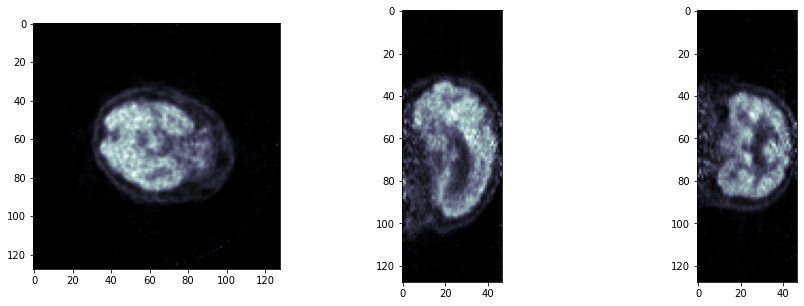

[[ 27   9   0   0   0   0   0  14  67 150 104  49  22  17  39 256 354  92
   16  25]
 [  0   0   0   0   0   0   0   0   8  30  18   5   3   3   4   2   3  23
  108 186]
 [  0   0   0   4  12   9   4   2   6  79 317 126  13   1   0   0   0   2
   16  38]
 [  2  30  62  16   1   0   3  97 211  66  23  21  28  39 108 143  18   0
    0   0]
 [174  34   7   1   0   4   5   2   0   0   0   2  17 139 315 145  68  76
   30   4]
 [ 51  24   7   9 120 264  55   5   1   2  41 306 526  84   4   1   4  15
   66  65]
 [  0   0   0   0   0   2   3   4  20 103 138  52  18  37 135 114  51  52
   40   9]
 [  0   0   0   0   0   0   0   0   2  11  11   4   4   8  64 379 216  12
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   1  15  57  75  61  64  71  28
    3   0]
 [  0   0   0   0   0   1   1   0   0   0   6  44 130 207 212 120 128 269
  176  32]]


In [289]:
# 随机载入一张nii图像
img = nib.load(np.random.choice(paths))
img = nib.load(paths[np.random.randint((len(paths)))])
print('Shown below are three slice of a {} image \nThe full 4D image has dimensions {}. We take a horizontal slice of it in around the middle'.format(type(img), img.shape))
# 取图像的三方向切片，并用热力图plt.imshow的bone风格显示
# img.dataobj 将nii图像转换为一个nDarray （此处只取了前两级自由度，所以是个切片）
img_slice_z = img.dataobj[:,:,round(img.shape[2])//3,0]
img_slice_x = img.dataobj[round(img.shape[0])//2,:,:,0]
img_slice_y = img.dataobj[:,round(img.shape[0])//2,:,0]
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].imshow(img_slice_z,cmap='bone')
axs[1].imshow(img_slice_x,cmap='bone')
axs[2].imshow(img_slice_y,cmap='bone')
plt.show()

# we show some data for a section of the image in the nDarray
print(img_slice_z[10:20,54:74])

## 步骤三：特征提取

对于深度学习任务，特征提取是非常重要的一步。在本例中，我们定义了一个函数`extract_feature`，用于从脑PET图像中提取特征。

`extract_feature`函数首先从文件路径加载PET四维图像数据img(四维 = 三维空间坐标 + 一维色相通道 此处第四维大小1代表黑白图像,3是红蓝绿通道）。随后将img转换为三维，并从中随机选择10个层合并成一个新的三维图像random_img。然后，计算一系列统计特征，如非零像素数量、零像素数量、平均值、标准差等。最后，函数根据文件路径判断样本类别，并将提取到的特征和类别作为返回值。

In [5]:
def extract_feature(path):
    '''
    Input: 一条文件路径
    Randomized Output: list = ['feature_vector of size 8', 'label']
    (randomness subject to coin-tosses of extraction np.random.choice)

    '''
    # 加载路径对应的PET图像数据
    img = nib.load(path)

    # 通过dataobj的method将四维图像数据转化为三维array
    img = img.dataobj[:, :, :, 0]

    # 从三维array的若干层二维图像中随机选出10层,构成一个随机三维array(127*127*10 3darray)
    random_img = img[:, :, np.random.choice(range(img.shape[2]), 10)]
    
    # 对random_img计算统计值
    feat = [
        (random_img != 0).sum(),               # 非零像素的数量
        (random_img == 0).sum(),               # 零像素的数量
        random_img.mean(),                     # 平均值
        random_img.std(),                      # 标准差
        len(np.where(random_img.mean(0))[0]),  # 在列方向上平均值不为零的数量
        len(np.where(random_img.mean(1))[0]),  # 在行方向上平均值不为零的数量
        random_img.mean(0).max(),              # 列方向上的最大平均值
        random_img.mean(1).max()               # 行方向上的最大平均值
    ]
    
    # 根据路径判断样本类别（'NC'表示正常，'MCI'表示异常）
    if 'NC' in path:
        return feat + ['NC']
    else:
        return feat + ['MCI']

In [265]:
extract_feature(paths[0])

[62375,
 101465,
 863.798681640625,
 2188.080388253523,
 1270,
 1257,
 3555.375,
 3983.34375,
 'MCI']

根据网络，PET扫描原理是利用正电荷核素标记的营养物质（如glucose）被有机体消耗的速度来判断细胞是否代谢正常,因此颜色占比比例可能是重要的因素之一。`extract_feature`虽然注意到了图像的占比特征（主要反映在非零像素数量，零像素数量，平均值等统计数据），但很可能不是很有效的nii图像特征提取方式。

根据之前切片观测，图片大部分都是黑色，且通过不停点上方随机extract feature我们发现零像素数量一直在60000左右浮动。同时注意到非零像素数量与零像素数量完全负相关，理论上其中一个应当去除。`extract_feature`也没有注意到图像边缘特征和纹理特征,这些可能可以通过小窗设计或者卷积解决。（不过还没学，不会，放着）

我们可以定义另外一种函数来提取图像特征，手动选取一些最重要的帮助诊断病症的统计数据。
比如，我们认为大片的零像素对应的是图像边界（观测数据可以得出），我们可以处理掉这些零像素，针对中间真正脑扫描的部分进行颜色占比分析。
如果有医学理论证实某一特定区域与认知障碍关系很大，我们也可以放大对那块区域的关注。




In [326]:
def extract_feature_alt(path, 
                        slice_ratio = 0.3,
                        fix_position = False, 
                        replace = False
                        ):
    '''
    给定一个nii路径，随机切片重组成三维图，统计七个feature，绑上label输出

    Input
        path: str,nii文件路径
        slice_ratio: float,选中切片占总切片数比值(default: 0.3)
        fix_position: boolean: 是否锁定切片位置(default: False)
        replace: boolean: 是否允许重复切片(default: False)
        

    Output(可能随机性)
        list = ['feature_vector of size 7', 'label']
    (randomness subject to coin-tosses of extraction np.random.choice)

    '''
    # 加载路径对应的PET图像数据
    img = nib.load(path)

    # 通过dataobj的method将四维图像数据转化为3darray
    img = img.dataobj[:, :, :, 0]
    num_slices = round(slice_ratio * img.shape[2])+1

    # 从三维数据图的若干层二维图像中随机选出10层 构成一个三维random_img (127*127*10 3darray)
    if fix_position == False:
        random_img = img[:, :, np.random.choice(range(img.shape[2]), num_slices,replace=replace)]
    else:
        Pass
    
    
    # 对三维的random_img计算统计值
    feat = [
        (random_img >= 10000).sum()/random_img.size,           # 像素值>=10000的比例
        random_img.mean(),                                     # 平均值
        random_img.std(),                                      # 标准差
        len(np.where(random_img.mean(0))[0]),                  # 在列方向上平均值不为零的数量
        len(np.where(random_img.mean(1))[0]),                  # 在行方向上平均值不为零的数量
        random_img.mean(0).max(),                              # 列方向上的最大平均值
        random_img.mean(1).max()                               # 行方向上的最大平均值
    ]
    
    # 根据路径判断样本类别（'NC'表示正常，'MCI'表示异常）
    if 'NC' in path:
        return feat + ['NC']
    else:
        return feat + ['MCI']

我把上面像素=0的部分换成了大于10000的部分，是因为下面这张图，调整threshold时感觉10000比较合适，能展现出图像间差异。
大于0的时候几乎体现不出是大脑扫描。

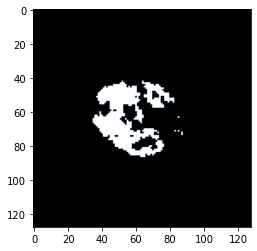

In [325]:
img_strengthened_z = img_slice_z > 10000
plt.imshow(img_strengthened_z,cmap='bone')

## 步骤四：模型训练

在这一步骤中，我们将利用`extract_feature`函数提取训练集和测试集的特征，并使用逻辑回归模型对训练集进行训练。

先定义一个函数将50个图像文件按一定比例分成训练集和测试集。



In [316]:
def generate_train_test_paths(paths,ratio = 0.6):
    '''
    Randomly generate *ratio* of paths as training sample, and remaining as testing samples.

    Input: list of paths; float of ratio default = 0.6.
    Ouptut: list of train_paths; list of test_paths
    '''

    # train_nums 内定义数量-1是为了保证至少有一个测试集。。。不然训练时会报错
    train_sample_ratio = ratio
    train_nums = np.random.choice(range(len(paths)), round(len(paths)*train_sample_ratio)-1,replace = False).tolist()
    test_nums = [num for num in range(len(paths)) if num not in train_nums]

    train_paths = [paths[num] for num in train_nums]
    test_paths = [paths[num] for num in test_nums]
    return(train_paths,test_paths)


def F1_score(true_labels, predicted_labels):
    '''
    Given two lists of booleans (one ground truth, one prediction), calculate the F_1 score

    Input: Two list of booleans, predictions and truth
    Output: Float, f1scoore
    '''

    true_labels_int = np.array(true_labels, dtype=int)
    predicted_labels_int = np.array(predicted_labels, dtype=int)
    # Calculate true positives, false positives, and false negatives
    TP = np.sum(np.logical_and(predicted_labels_int == 1, true_labels_int == 1))
    FP = np.sum(np.logical_and(predicted_labels_int == 1, true_labels_int == 0))
    FN = np.sum(np.logical_and(predicted_labels_int == 0, true_labels_int == 1))
    # Calculate precision and recall
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    # Calculate F1-score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return(f1_score)

在这里，我们通过循环将特征提取过程重复进行30次，这是为了增加训练样本的多样性。然后，我们使用逻辑回归模型`LogisticRegression`来训练数据。在训练完成后，模型已经学习到了从特征到类别的映射关系。

In [327]:
## 以下开始训练模型
## 自定义训练集,占总样本比率：60%.
train_paths,test_paths = generate_train_test_paths(paths,ratio = 0.7)

# 循环30次，每次对训练集中的每个图像进行特征提取，每个提取后的[特征&类别]（'NC'表示正常，'MCI'表示异常）被添加到train_feat列表中。
# train_feat列表于是包含以下图像标号顺序的 30*训练集大小 个[特征&类别]: [1号,2号,...,最大号，...,1号,2号,...最大号]

traindata = []
for _ in range(30):
    for path in train_paths:
        # 可以选择使用随意的一种feature extraction做实验
        # traindata.append(extract_feature(path))
        traindata.append(extract_feature_alt(path))
     
# 对测试集中每个图像也进行30次特征提取   
testdata = []
for _ in range(30):
    for path in test_paths:
        # testdata.append(extract_feature(path))
        testdata.append(extract_feature_alt(path))
        
# 使用训练集的特征作为输入，训练集的类别作为输出，对逻辑回归模型进行训练。
## The fitting function of LogReg intakes (2darray-of-samples'features, 1darray-of-labels). 
## Note train_feat was initially a vector of vectors, need to convert to 2darray via np.array first.
from sklearn.linear_model import LogisticRegression
m = LogisticRegression(max_iter=1000)
train_feat = np.array(traindata)[:, :-1].astype(np.float32)
train_label = np.array(traindata)[:, -1]  
test_feat = np.array(testdata)[:, :-1].astype(np.float32)
test_label = np.array(testdata)[:, -1]  

# 用模型来预测测试集
m.fit(train_feat, train_label)
test_pred = m.predict(test_feat)

# 计算F1_score
test_label_boolean = [False if i == 'NC' else True for i in test_label]
test_pred_boolean = [False if i == 'NC' else True for i in test_pred]
f1_score = F1_score(test_label_boolean,test_pred_boolean)
print(f1_score)

0.5676274944567627


在`scikit-learn`（sklearn）中，除了逻辑回归（Logistic Regression）之外，还有许多其他的机器学习模型可以用于分类任务中，以下是一些常用于分类任务的机器学习模型：

1. 支持向量机（Support Vector Machines，SVM）：用于二分类和多分类问题，通过构建一个超平面来区分不同类别的样本。
2. 决策树（Decision Trees）：适用于二分类和多分类问题，通过对特征空间进行划分来分类样本。
3. 随机森林（Random Forests）：基于多个决策树的集成算法，用于二分类和多分类问题，提高了模型的泛化能力。
4. K最近邻算法（K-Nearest Neighbors，KNN）：根据最近邻样本的类别来分类新样本，适用于二分类和多分类问题。
5. 朴素贝叶斯（Naive Bayes）：基于贝叶斯定理的分类方法，适用于文本分类等问题。
6. 多层感知器（Multi-layer Perceptrons，MLP）：一种人工神经网络，用于解决复杂的分类问题。
7. 卷积神经网络（Convolutional Neural Networks，CNN）：专用于处理图像和视觉数据的神经网络，在图像分类任务中表现出色。

这些模型在分类任务中有不同的应用场景和性能表现，取决于数据集的特征、样本数量和问题的复杂性。在实际应用中，通常需要根据数据集的特点和具体任务来选择合适的分类模型，并进行模型调参和性能评估，以达到最佳的分类效果。

## 步骤五：预测与结果提交

在这一步骤中，我们使用训练好的逻辑回归模型对测试集进行预测，并将预测结果进行投票，选出最多的类别作为该样本的最终预测类别。最后，我们将预测结果存储在CSV文件中并提交结果。

具体来说，我们使用了`Counter`来统计每个样本的30次预测结果中最多的类别，并将结果存储在`test_pred_label`列表中。然后，我们将样本ID和对应的预测类别存储在一个DataFrame中，并将其按照ID排序后保存为CSV文件，这样我们就得到了最终的结果提交文件。

In [37]:
# ## Reshapping an array (-1 is "adapting to remaining dimensions")

# a = np.array([[1,2,3,4,5,6]])
# print(a.shape)
# a = a.reshape(3,2)
# print(a)
# a = a.reshape(-1,3)
# print(a)

In [38]:
# 对测试集进行预测并进行转置操作，使得每个样本有30次预测结果。
test_pred = m.predict(np.array(test_feat)[:, :-1].astype(np.float32))
# test_pred现在存储了1-100号测试数据的共3000次预测结果，顺序为[1号,2号,...,100号,....,1号,2号,...,100号]
# reshape 成为30行[1号,2号,...,100号]的预测结果，再转置就变成了1号至100号的各30次预测结果
# test_pred 是100*30的2darray
test_pred = test_pred.reshape(30, -1).T

# 对每个样本的30次预测结果进行投票，选出最多的类别作为该样本的最终预测类别，存储在test_pred_label列表中。
test_pred_label = [Counter(x).most_common(1)[0][0] for x in test_pred]

# 生成提交结果的DataFrame，其中包括样本ID和预测类别。
submit = pd.DataFrame(
    {
        'uuid': [int(x.split('/')[-1][:-4]) for x in test_path],  # 提取测试集文件名中的ID
        'label': test_pred_label                                  # 预测的类别
    }
)

# 按照ID对结果排序并保存为CSV文件
submit = submit.sort_values(by='uuid')
submit.to_csv('submit.csv', index=None)

在提交结果处提交，提交 submit.csv 文件，在排名结果页查看自己的成绩排名。

![](https://ai-studio-static-online.cdn.bcebos.com/d6e838b8280740b6afeda5f4c3931c8503b8e6cbb69b43a39a332f8949b6a3d8)


## 总结

本篇baseline介绍了如何使用Python编程语言和机器学习库处理脑PET图像数据，并构建逻辑回归模型来进行脑PET图像的疾病预测。特征提取是一个关键步骤，通过合适的特征提取方法，可以更好地表征图像数据。逻辑回归模型在本例中是一个简单而有效的分类器，但在实际应用中，可能需要更复杂的深度学习模型来提高预测性能。希望本篇baseline对你学习深度学习在医学图像处理中的应用有所帮助！

如果你对这个挑战赛感兴趣，不妨动手尝试一下。你可以在竞赛中改进模型和特征提取方法，或者尝试使用其他深度学习模型来进行预测。祝你好运！